In [4]:
import matplotlib.pyplot as plt
import os

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

from ase.build import bulk
from abtem import show_atoms, FrozenPhonons, Probe, Potential, GridScan, AnnularDetector

Runtime: 30 s per frozen phonon on 1 NVidia RTX 2080 Ti

In [5]:
cluster = LocalCUDACluster(memory_limit='10gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [6]:
client

Client Scheduler: tcp://127.0.0.1:49513 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 9.31 GiB


In [25]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (4, 4, 20)

In [26]:
chunks = 500 # max number of wave functions in each chunk

frozen_phonons = FrozenPhonons(atoms, 1, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=512, 
                      device='gpu', 
                      projection='infinite', 
                      slice_thickness=1)

probe = Probe(energy=100e3, semiangle_cutoff=20, device='gpu')
scan = GridScan()
detectors = AnnularDetector(50, 150, to_cpu=True)
measurement = probe.scan(scan, detectors, potential, chunks=chunks)

In [27]:
probe.build(scan, chunks).array # For showing the size of the chunks

dask.array<calculate_probes, shape=(53, 53, 512, 512), dtype=complex64, chunksize=(22, 22, 512, 512), chunktype=numpy.ndarray>

In [28]:
%%time
measurement.compute()

Wall time: 29.4 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x2851da935b0>)

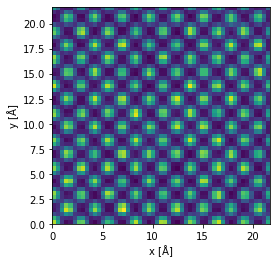

In [29]:
measurement.show()